In [1]:
import gc
import pathlib

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

In [8]:
%run ../wmis_gnn_py/util/metis.py
%run ../wmis_gnn_py/util/gurobi_wmis.py
%run ../wmis_gnn_py/util/subgraph.py
%run ../wmis_gnn_py/util/greedy.py
%run ../wmis_gnn_py/util/pyg_interface.py
%run ../wmis_gnn_py/arch/wmvc.py

# Small Erdos-Reyni Graphs

In [23]:
er_paths = list(yield_metis_filenames("../data/erdos_reyni_small/"))
er_labels = list(yield_solution_filenames("../data/erdos_reyni_small/label"))
pace_paths = list(yield_metis_filenames("../data/pace_weighted/"))

In [27]:
er_labels[0].stat().st_size

400

In [213]:
G = metis_to_nx(er_paths[0])

In [143]:
G_prime = G.copy()
solution_to_nx(G_prime, er_labels[0])
assert is_independent(G_prime)

opt_weight = sum(
    G_prime.nodes[v]["weight"]
    for v in G_prime.nodes
    if G_prime.nodes[v]["solution"] == 1.0
)
opt_weight

9554

In [144]:
wmis_lp(G)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads
Optimize a model with 2013 rows, 200 columns and 4026 nonzeros
Model fingerprint: 0x2efff399
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 2013 rows, 200 columns, 4026 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4125662e+04   1.528150e+03   0.000000e+00      0s
     172    1.8774500e+04   0.000000e+00   0.000000e+00      0s

Solved in 172 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.877450000e+04


In [145]:
H = get_unsolved_view(G)

In [146]:
greedy_wmis(H)
assert is_independent(G)

In [147]:
sum(G.nodes[v]["weight"] for v in G.nodes if G.nodes[v]["solution"] == 1.0) / opt_weight

0.6102156164957087

# PyG

In [29]:
import torch
import torch_geometric as pyg
from torch.nn import functional as F

In [30]:
torch.cuda.is_available()

True

In [48]:
dataset = WMISDataset(
    "../data/pace_weighted/",
    node_limit=1000,
    transform=pyg.transforms.AddLaplacianEigenvectorPE(
        k=2, attr_name=None, is_undirected=True
    ),
).shuffle()
# dataset = torch.load("test.pt")
print(len(dataset))

loader_train = pyg.loader.DataLoader(dataset[:4000], batch_size=128, shuffle=True)
loader_eval = pyg.loader.DataLoader(dataset[4000:], batch_size=128, shuffle=True)

4797


In [49]:
dataset[0]

Data(edge_index=[2, 1728], weight=[200], solution=[200], id=[200], x=[200, 5])

## GCN

In [73]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        assert len(hidden_channels) == 2

        super().__init__()

        # TODO: Define two GCNConv modules and a ReLU function.
        # The input size and output size of first GCNConv module should be in_channels and hidden_channels
        # The input size and output size of second GCNConv module should be hidden_channels and out_channels

        ############# Your code here ############
        ## (~3 line of code)

        self.conv1 = pyg.nn.GINConv(
            nn=MLP(in_channels, 32, hidden_channels[0]),
            train_eps=True,
        )
        self.conv2 = pyg.nn.GINConv(
            nn=MLP(hidden_channels[0], 32, hidden_channels[1]),
            train_eps=True,
        )
        self.conv3 = pyg.nn.GINConv(
            nn=MLP(hidden_channels[1], 32, out_channels),
            train_eps=True,
        )
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        #########################################

    def forward(self, node_feature, edge_index):

        output = None

        # TODO: Use the modules you define in __init__ to perform message passing.
        # ReLU function should be used in the middle of two GCNConv modules.

        ############# Your code here ############
        ## (~3 line of code)
        result_conv1 = self.conv1(node_feature, edge_index)
        result_relu1 = F.relu(result_conv1)
        result_conv2 = self.conv2(result_relu1, edge_index)
        result_relu2 = F.relu(result_conv2)
        result_conv3 = self.conv3(result_relu2, edge_index)
        # skip connections
        output = self.log_softmax(result_conv3 + result_relu1 + result_relu2)
        #########################################

        return output

## MLP

In [50]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # TODO: Define two Linear modules and a ReLU function.
        # The input size and output size of first Linear module should be input_dim and hidden_dim
        # The input size and output size of second Linear module should be hidden_dim and output_dim

        ############# Your code here ############
        ## (~3 line of code)
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels

        self.sequential = torch.nn.Sequential(
            pyg.nn.Linear(in_channels, hidden_channels),
            torch.nn.Dropout(p=0.2),
            torch.nn.ReLU(),
            pyg.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.Dropout(p=0.2),
            torch.nn.ReLU(),
            pyg.nn.Linear(hidden_channels, out_channels),
            torch.nn.Dropout(p=0.2),
        )
        #########################################

    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # reshape the tensor to a 1-D vector

        out = 0

        # TODO: Use the modules you define in __init__ to perform calculation.
        # ReLU function should be used in the middle of two Linear modules.

        ############# Your code here ############
        ## (~3 line of code)
        out = self.sequential(x)
        #########################################

        return out

## Replicate Paper

In [51]:
class WMVC(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # TODO: Define two GCNConv modules and a ReLU function.
        # The input size and output size of first GCNConv module should be in_channels and hidden_channels
        # The input size and output size of second GCNConv module should be hidden_channels and out_channels

        ############# Your code here ############
        ## (~3 line of code)

        self.spec_conv = pyg.nn.ChebConv(
            in_channels, 2, improved=True, normalization=None, K=4
        )
        self.gat_conv = pyg.nn.GATv2Conv(
            in_channels, 2, heads=1, concat=True, dropout=0.2
        )
        self.conv1 = pyg.nn.LGConv(
            normalize=False, aggr=pyg.nn.aggr.MultiAggregation(["add", "max"])
        )
        self.mlp1 = MLP(-1, hidden_channels, hidden_channels // 2)
        self.conv2 = pyg.nn.LGConv(
            normalize=False, aggr=pyg.nn.aggr.MultiAggregation(["add", "max"])
        )
        self.mlp2 = MLP(-1, hidden_channels, hidden_channels // 2)
        self.conv3 = pyg.nn.LGConv(
            normalize=False, aggr=pyg.nn.aggr.MultiAggregation(["add", "max"])
        )
        self.mlp3 = MLP(-1, hidden_channels, out_channels)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        #########################################

    def forward(self, node_feature, edge_index):

        output = None

        # TODO: Use the modules you define in __init__ to perform message passing.
        # ReLU function should be used in the middle of two GCNConv modules.

        ############# Your code here ############
        ## (~3 line of code)
        result_spec = self.spec_conv(node_feature, edge_index)
        result_gat = self.gat_conv(node_feature, edge_index)
        result_concat0 = torch.concat([result_spec, result_gat, node_feature], dim=1)

        result_conv1 = self.conv1(result_concat0, edge_index)
        result_concat1 = torch.concat([result_conv1, node_feature], dim=1)
        result_mlp1 = self.mlp1(result_concat1)
        result_act1 = torch.relu(result_mlp1)

        result_conv2 = self.conv2(result_act1, edge_index)
        result_concat2 = torch.concat([result_conv2, result_act1, node_feature], dim=1)
        result_mlp2 = self.mlp2(result_concat2)
        result_act2 = torch.relu(result_mlp2)

        result_conv3 = self.conv3(result_act2, edge_index)
        result_concat3 = torch.concat([result_conv3, result_act2, node_feature], dim=1)
        result_mlp3 = self.mlp3(result_concat3)

        output = self.log_softmax(result_mlp3)
        #########################################

        return output

In [52]:
model = WMVC(5, 32, 2).cuda()
model.eval()

WMVC(
  (spec_conv): ChebConv(5, 2, K=4, normalization=None)
  (gat_conv): GATv2Conv(5, 2, heads=1)
  (conv1): LGConv()
  (mlp1): MLP(
    (sequential): Sequential(
      (0): Linear(-1, 32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(32, 32, bias=True)
      (4): Dropout(p=0.2, inplace=False)
      (5): ReLU()
      (6): Linear(32, 16, bias=True)
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (conv2): LGConv()
  (mlp2): MLP(
    (sequential): Sequential(
      (0): Linear(-1, 32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(32, 32, bias=True)
      (4): Dropout(p=0.2, inplace=False)
      (5): ReLU()
      (6): Linear(32, 16, bias=True)
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (conv3): LGConv()
  (mlp3): MLP(
    (sequential): Sequential(
      (0): Linear(-1, 32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(32, 32, bias=True)
      (4): D

In [53]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    # weight_decay=1e-4,
    nesterov=True,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    patience=5,
    cooldown=5,
    verbose=True,
)
class_weight = weight = torch.Tensor([0.2, 0.8]).cuda()
loss_fn = torch.nn.NLLLoss(weight=class_weight)

In [54]:
def train(model, training_set, optimizer, loss_fn):
    loss = 0

    # TODO: Define train function.
    # 1. put the model into train mode
    # 2. clear the gradients calculated from the last batch
    # 3. get the prediction by model
    # 4. calculate the loss between our predictions and the actual labels.
    # Just using nodes in train set!
    # 5. calculate the gradients of each parameter
    # 6. update the parameters by taking an optimizer step

    ############# Your code here ############
    ## (~7 line of code)
    model.train()
    optimizer.zero_grad()
    y_pred = model(data.x, data.edge_index)
    loss = loss_fn(y_pred, data.solution.long().reshape(-1))
    loss.backward()
    optimizer.step()
    #########################################

    return loss.cpu()

In [55]:
@torch.no_grad()
def test(model, data):
    # TODO: Define test function.
    # 1. put the model into eval mode
    # 2. get the prediction by model
    # 3. calculate the accuracy for each set
    # NOTE: the results should be a list containing the accuracy of different set

    ############# Your code here ############
    ## (~5 line of code)
    model.eval()
    y_pred = torch.exp(model(data.x, data.edge_index))
    pred = y_pred.argmax(dim=1, keepdim=False)
    assert pred.shape == data.solution.shape
    acc = pred.eq(data.solution).float().mean()

    batch_ids = torch.unique(data.batch)
    acc_10, acc_1 = [], []
    for batch_id in batch_ids:
        y_pred_batch_sorted, indices = y_pred[data.batch == batch_id].sort(
            dim=0, descending=True
        )
        # print(y_pred_batch_sorted)
        solution_batch = data.solution[data.batch == batch_id]
        # print(solution_batch)
        acc_10.append(solution_batch[indices[:10, 1]].eq(1).float().mean().cpu())
        acc_1.append(solution_batch[indices[0, 1]].eq(1).float().cpu())
    #########################################

    # print(acc.cpu(), np.mean(acc_10), np.mean(acc_1))
    return acc.cpu(), np.mean(acc_10), np.mean(acc_1)

In [56]:
from tqdm.notebook import tqdm

num_epochs = 10
epochs = list(range(1, num_epochs + 1))
train_loss, train_acc, train_acc_10, train_acc_1, eval_acc, eval_acc_10, eval_acc_1 = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

# best_eval_acc = float("-inf")
for epoch in tqdm(epochs, position=0, leave=True, desc="epoch"):
    train_loss_curr = 0.0
    train_acc_curr, train_acc_10_curr, train_acc_1_curr = 0.0, 0.0, 0.0
    for data in tqdm(loader_train, position=1, leave=False, desc="training batch"):
        loss = train(model, data.cuda(), optimizer, loss_fn).detach()
        train_loss_curr += loss / len(loader_train)

        acc, acc_10, acc_1 = test(model, data.cuda())
        train_acc_curr += acc / len(loader_train)
        train_acc_10_curr += acc_10 / len(loader_train)
        train_acc_1_curr += acc_1 / len(loader_train)

    eval_acc_curr, eval_acc_10_curr, eval_acc_1_curr = 0.0, 0.0, 0.0
    for data in tqdm(loader_eval, position=1, leave=False, desc="eval batch"):
        acc, acc_10, acc_1 = test(model, data.cuda())
        eval_acc_curr += acc / len(loader_eval)
        eval_acc_10_curr += acc_10 / len(loader_eval)
        eval_acc_1_curr += acc_1 / len(loader_eval)

    # scheduler.step(eval_acc_10_curr)

    train_loss.append(train_loss_curr)
    train_acc.append(train_acc_curr)
    train_acc_10.append(train_acc_10_curr)
    train_acc_1.append(train_acc_1_curr)
    eval_acc.append(eval_acc_curr)
    eval_acc_10.append(eval_acc_10_curr)
    eval_acc_1.append(eval_acc_1_curr)

    if epoch % 5 == 0:
        print(f"After epoch {epoch}:")
        print(
            f"train acc: {train_acc_curr}, train acc_10: {train_acc_10_curr}, train acc_1: {train_acc_1_curr},"
        )
        print(
            f"eval acc: {eval_acc_curr}, eval acc_10: {eval_acc_10_curr}, eval acc_1: {eval_acc_1_curr}"
        )
        print(
            "----------------------------------------------------------------------------------------"
        )

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training batch:   0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

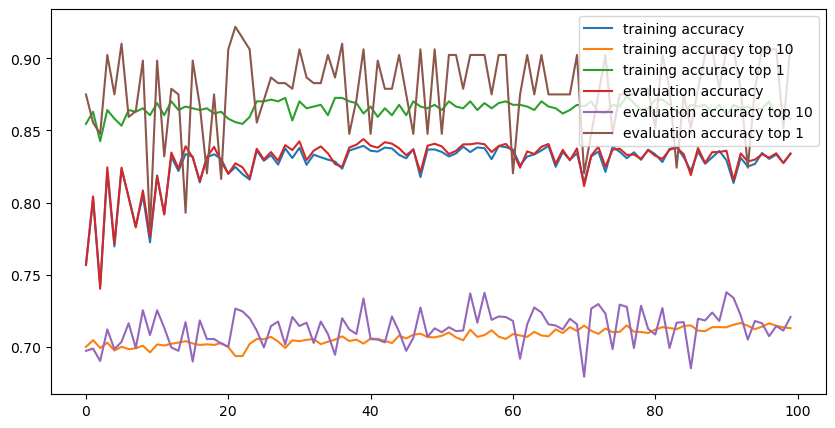

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.twinx().plot(train_loss, color="blue", label="training loss")
ax.plot(train_acc, label="training accuracy")
ax.plot(train_acc_10, label="training accuracy top 10")
ax.plot(train_acc_1, label="training accuracy top 1")
ax.plot(eval_acc, label="evaluation accuracy")
ax.plot(eval_acc_10, label="evaluation accuracy top 10")
ax.plot(eval_acc_1, label="evaluation accuracy top 1")
ax.legend()

In [169]:
with torch.no_grad():
    idx = 9
    y_pred = torch.exp(model(dataset[idx].x.cuda(), dataset[idx].edge_index.cuda()))
    y_pred_sorted, indices = y_pred.sort(dim=0, descending=True)
    # print(y_pred_sorted)
    print(dataset[idx].solution[indices[0:10, 1]])

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])


In [430]:
# torch.save(model, "WMVC_erdos_reyni_small.pt")

# PACE 2019 Competition Graphs

In [15]:
len(list(yield_solution_filenames("../data/pace_weighted/label")))

18197

In [6]:
rows = []

filepaths = list(yield_metis_filenames("../data/pace_unweighted/"))
# print(filepaths)
for filepath in tqdm(filepaths):
    path = filepath.resolve()
    # print(path)
    G = metis_to_nx(path)
    rows.append(pd.Series({"order": G.order(), "name": path.stem}))

    gc.collect()

df_pace = pd.DataFrame(rows).set_index("name")
df_pace

100%|██████████| 200/200 [00:46<00:00,  4.29it/s]


,order
name,
vc-exact_001,6160
vc-exact_002,51795
vc-exact_003,60541
vc-exact_004,8114
vc-exact_005,200
...,...
vc-exact_196,1534
vc-exact_197,1534
vc-exact_198,1150


In [7]:
# df_pace.to_csv("pace_unweighted.csv")

In [13]:
df_pace.order.le(10000).sum()

92

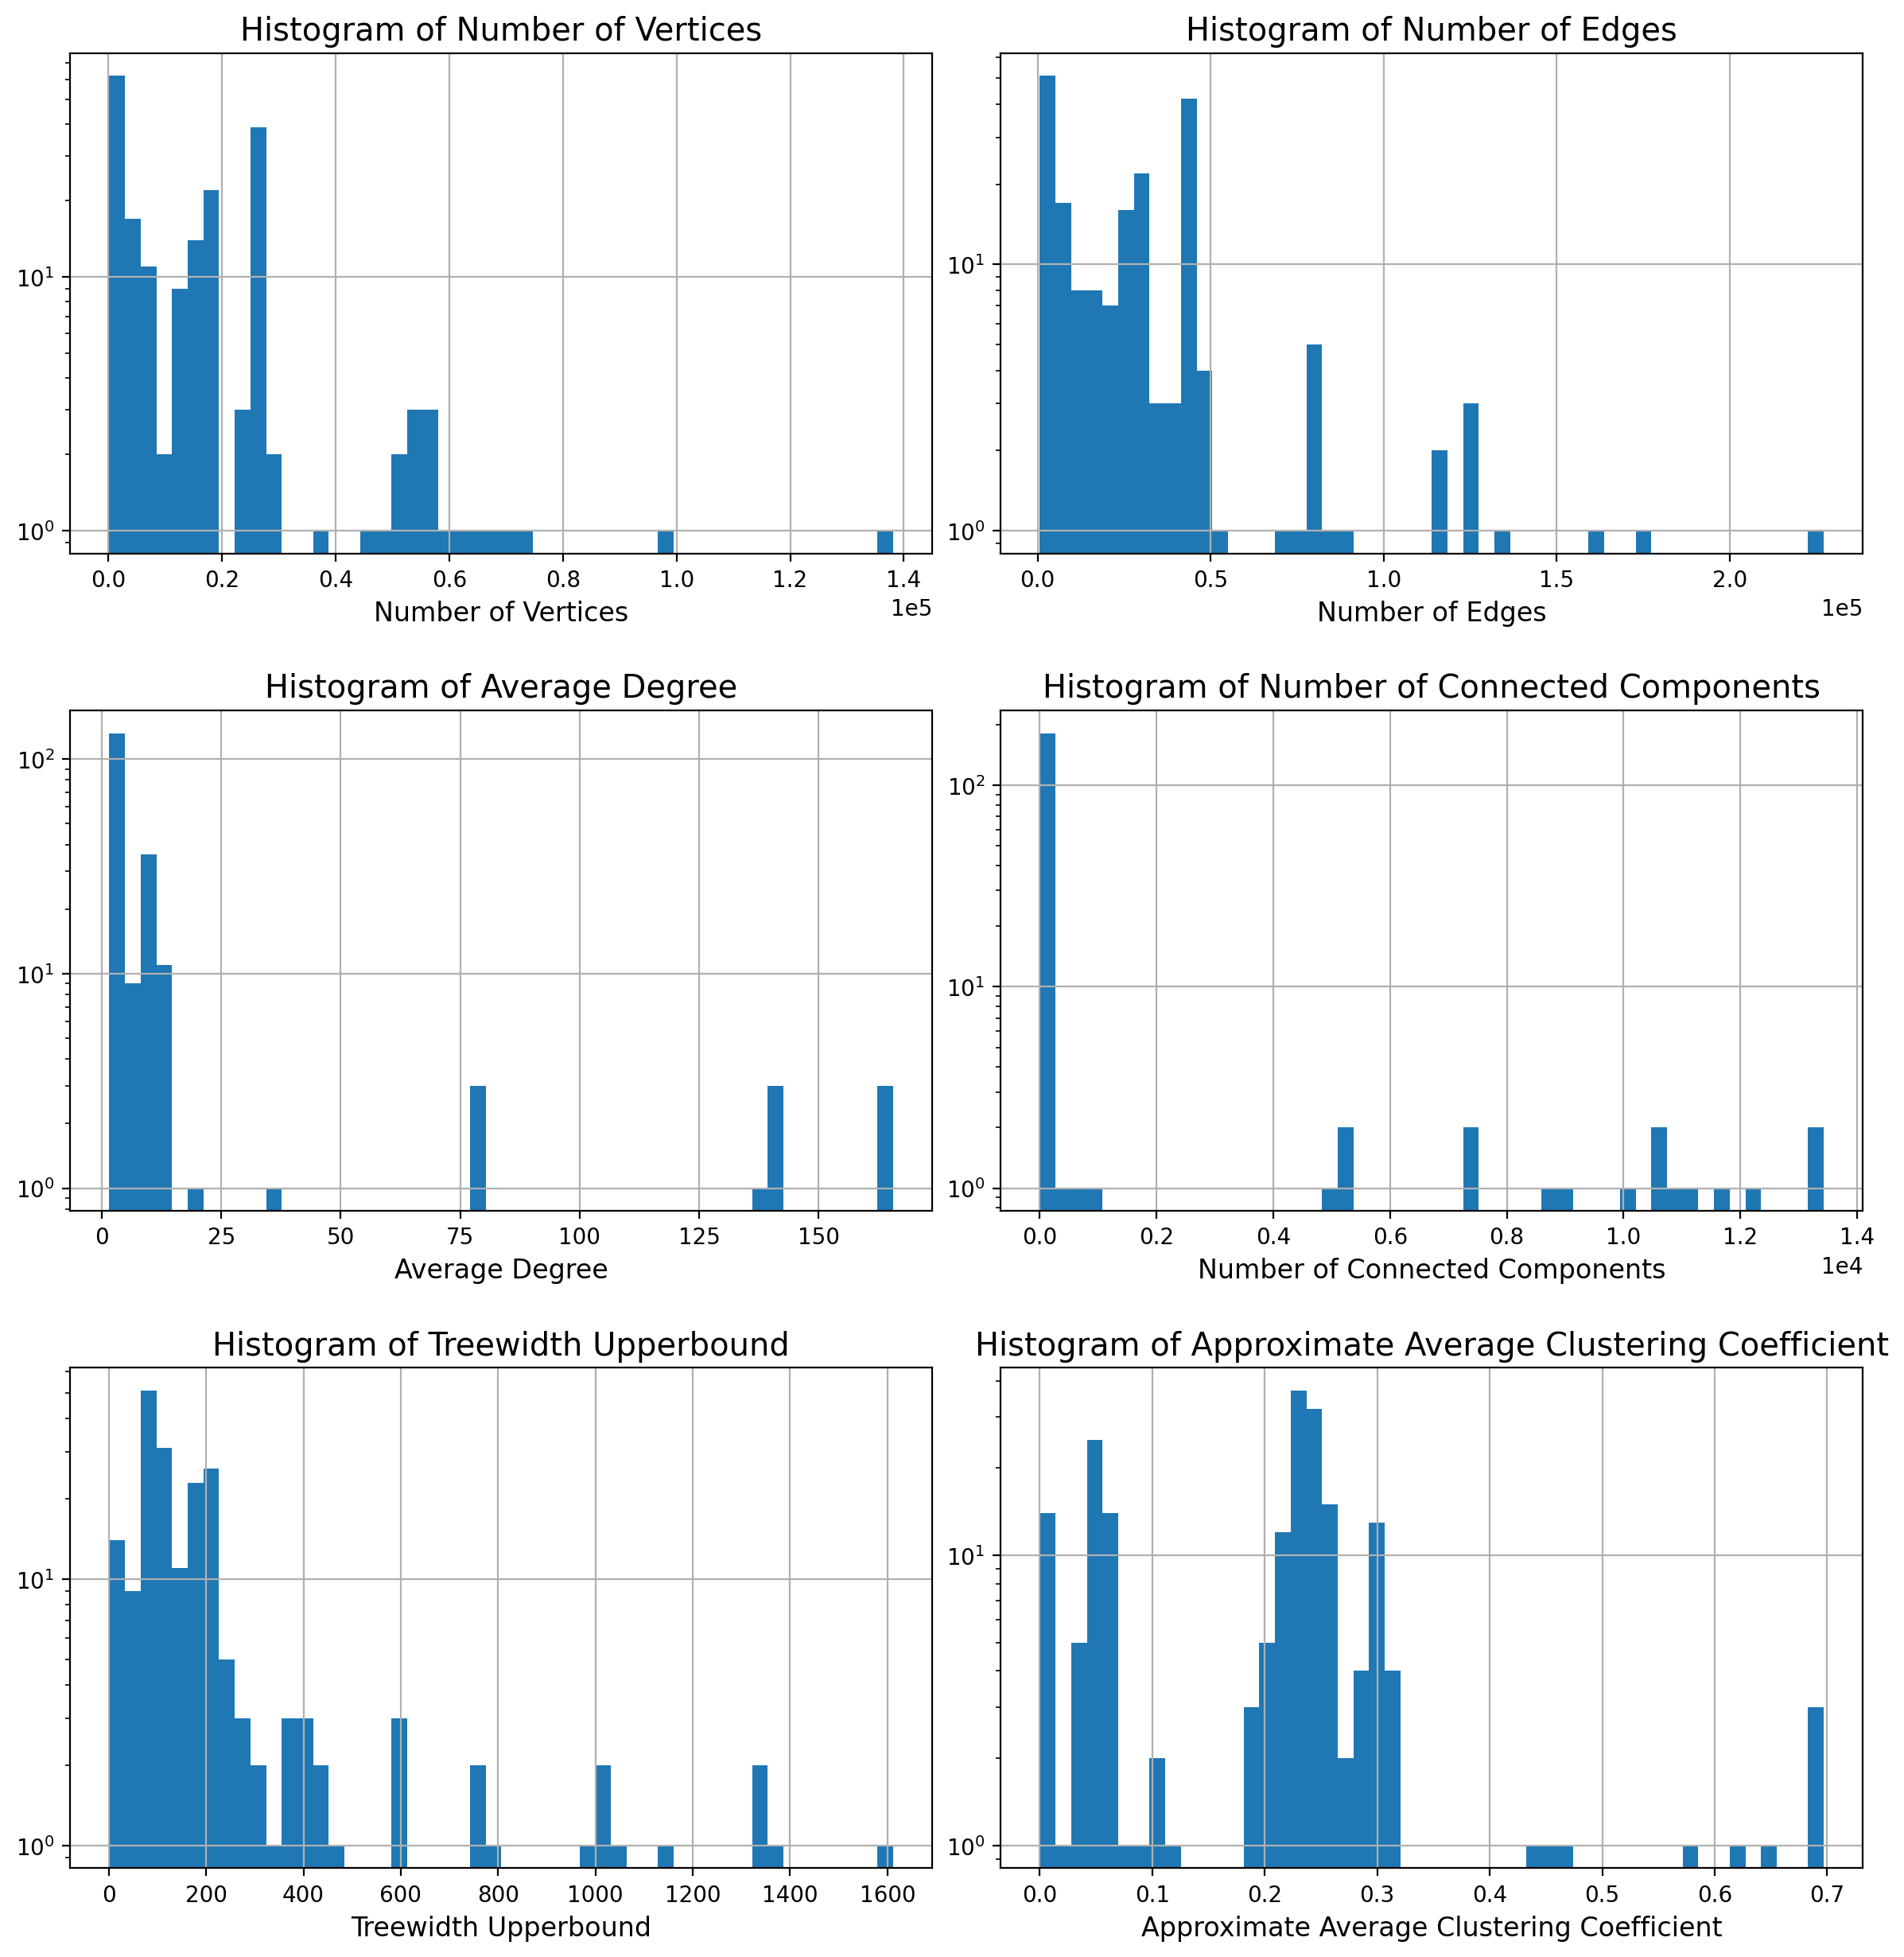

In [4]:
# df_pace = pd.read_csv("pace_unweighted.csv")

plot_graph_df(df_pace)
plt.savefig("pace_unweighted.pdf", bbox_inches="tight")

# Checking for Inverse

In [9]:
er_paths = list(yield_metis_filenames("../data/erdos_reyni_small/"))
er_labels = list(yield_solution_filenames("../data/erdos_reyni_small/label"))

In [10]:
G = metis_to_nx(er_paths[0])
solution_to_nx(G, er_labels[0])

In [11]:
H = tensor_to_nx(nx_to_tensor(G))

In [15]:
len(G.nodes & H.nodes)

200

In [16]:
G.edges - (G.edges & H.edges)

set()

In [17]:
H.edges - (G.edges & G.edges)

set()

In [18]:
nx.get_node_attributes(G, "weight") == nx.get_node_attributes(H, "weight")

True

In [19]:
nx.get_node_attributes(G, "solution") == nx.get_node_attributes(H, "solution")

True

# Heuristic

In [20]:
model = WMVC(7, 32, 2)

In [22]:
model.load_state_dict(torch.load("../models/wmvc_er_small/wmvc_er_small_epoch00006.pt"))

<All keys matched successfully>

In [23]:
data = nx_to_tensor(G)
data

Data(edge_index=[2, 4026], weight=[200], solution=[200], id=[200], x=[200, 7])

In [24]:
with torch.no_grad():
    print(torch.exp(model(data.x, data.edge_index)))

tensor([[0.4900, 0.5100],
        [0.5032, 0.4968],
        [0.5554, 0.4446],
        [0.4812, 0.5188],
        [0.4645, 0.5355],
        [0.4839, 0.5161],
        [0.5813, 0.4187],
        [0.4719, 0.5281],
        [0.5267, 0.4733],
        [0.5000, 0.5000],
        [0.5024, 0.4976],
        [0.4880, 0.5120],
        [0.4676, 0.5324],
        [0.4796, 0.5204],
        [0.5082, 0.4918],
        [0.4943, 0.5057],
        [0.4535, 0.5465],
        [0.4488, 0.5512],
        [0.5385, 0.4615],
        [0.5221, 0.4779],
        [0.4489, 0.5511],
        [0.5357, 0.4643],
        [0.5466, 0.4534],
        [0.5290, 0.4710],
        [0.5739, 0.4261],
        [0.4964, 0.5036],
        [0.4377, 0.5623],
        [0.5424, 0.4576],
        [0.5417, 0.4583],
        [0.5033, 0.4967],
        [0.5514, 0.4486],
        [0.5209, 0.4791],
        [0.5881, 0.4119],
        [0.4917, 0.5083],
        [0.5144, 0.4856],
        [0.4486, 0.5514],
        [0.5123, 0.4877],
        [0.5352, 0.4648],
        [0.4